In [108]:
"""  """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNetCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import set_config
from pickle import dump, load

In [109]:
"""  """

seed = 14+13*2#dia-nacimiento-estudiante + 13 * mes-nacimiento-estudiante
seed

40

## Data cleansing

### Read dataset

In [110]:
""" Lee el dataframe de sklearn llamado 'fetch_kddcup99' y almacenarlo en una variable llamada data """

from sklearn.datasets import fetch_kddcup99

data = fetch_kddcup99(as_frame=True)
pd_data = data.frame
pd_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'tcp',b'http',b'SF',181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,b'normal.'
1,0,b'tcp',b'http',b'SF',239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,b'normal.'
2,0,b'tcp',b'http',b'SF',235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,b'normal.'
3,0,b'tcp',b'http',b'SF',219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,b'normal.'
4,0,b'tcp',b'http',b'SF',217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,b'normal.'


### Column selector

In [111]:
""" De entre todas las variables del dataframe, solo trabajaremos en 
    este ejercicio con las descritas en key_columns, por lo que tendréis que quitar el resto """

key_columns = ['duration', 'protocol_type', 'service', 'flag', 'logged_in', 'count', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate', 'labels']

pd_data = pd_data[key_columns]
pd_data.head()
print(pd_data.shape)

(494021, 11)


### Duplicates 

In [112]:
""" Comprobad que no haya nulos ni registros duplicados """


# codigo-alumno
#Se comprueba que si hay nulos en las variables
pd_data.isnull().sum()


duration                    0
protocol_type               0
service                     0
flag                        0
logged_in                   0
count                       0
srv_count                   0
serror_rate                 0
dst_host_srv_count          0
dst_host_srv_serror_rate    0
labels                      0
dtype: int64

In [113]:
#Se comprueba si hay registros duplicados en las variables
print('el número de duplicados es', pd_data.duplicated().sum())

# length initial
length1=  len(pd_data)

# dropping duplicate values
pd_data.drop_duplicates(keep=False, inplace=True)
 
# length after removing duplicates
length2=len(pd_data)
 
# printing all data frame lengths
print('el tamaño inicial del dataframe es',length1,'y el tamaño despues de quitar duplicados es',length2)




el número de duplicados es 439856
el tamaño inicial del dataframe es 494021 y el tamaño despues de quitar duplicados es 36963


### Analisys target variable

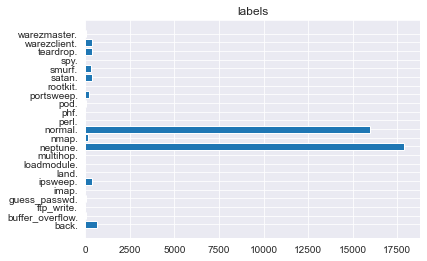

In [114]:
""" Mostrar un barplot para la variable objetivo (labels)"""

target = 'labels'

# codigo-alumno
k = pd_data.groupby('labels').size()
plt.barh(k.index, k)
plt.title('labels')
plt.ylabel
plt.show()


In [115]:
#Eliminar los caracteres especiales, se codifica
pd_data['labels'] = pd_data.labels.str.decode('utf-8')

In [116]:
pd_data.groupby('labels').size().sort_values(ascending=False)


labels
neptune.            17880
normal.             15989
back.                 668
teardrop.             404
warezclient.          388
ipsweep.              376
satan.                367
smurf.                311
portsweep.            229
nmap.                 129
pod.                   54
guess_passwd.          53
buffer_overflow.       28
warezmaster.           20
land.                  14
imap.                  12
loadmodule.             9
rootkit.                8
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
dtype: int64

In [117]:
""" Dado que hay dos etiquetas que se repiten con mayor frecuencia, 
    transformad la variable labels para que tenga un valor booleano que indique 
    si es la etiqueta más frecuente o la segunda más frecuente, 
    los demás registros los eliminaremos de este estudio """

# codigo-alumno



pd_data['labels'] = pd_data.labels.apply(lambda x: 1 if x=='neptune.' else x)# codigo-a
pd_data['labels'] = pd_data.labels.apply(lambda x: 0 if x=='normal.' else x)# codigo-a
pd_data['labels'] = pd_data.labels.apply(lambda x: 2 if (x!=1)&( x!=0) else x)# codigo-a
pd_data.groupby('labels').size().sort_values(ascending=False)

labels
1    17880
0    15989
2     3094
dtype: int64

In [118]:
pd_data = pd_data[pd_data.labels <2 ]

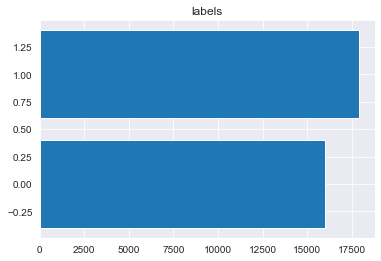

In [119]:
""" Volved a mostrar el barplot para la variable objetivo (labels) """

# codigo-alumno
target = 'labels'

k = pd_data.groupby('labels').size()
plt.barh(k.index, k)
plt.title('labels')
plt.ylabel
plt.show()


In [120]:
pd_data.groupby('labels').size().sort_values(ascending=False)

labels
1    17880
0    15989
dtype: int64

### Analisys imput variables 

Se van a ralizar dos análisis de las variables, la opcion A es la marcada en el enunciado y la opción B es una que planta algunos cambios.

##### Separate types of variables

In [121]:
#para evitar usar la palabra count que es un comando en Python
pd_data.rename(columns={'count':'count1'}, inplace=True)
pd_data1=pd_data.copy()

In [122]:
""" Separaremos las variables categóricas de las numéricas """


num_cols = ['duration', 'count1', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']
cat_cols = ['protocol_type', 'service', 'flag', 'logged_in']

pd_data[num_cols] = pd_data[num_cols].astype(float)

#### Analisys numerical variables (A-option)

##### Histogram numeric variables

<function matplotlib.pyplot.show(close=None, block=None)>

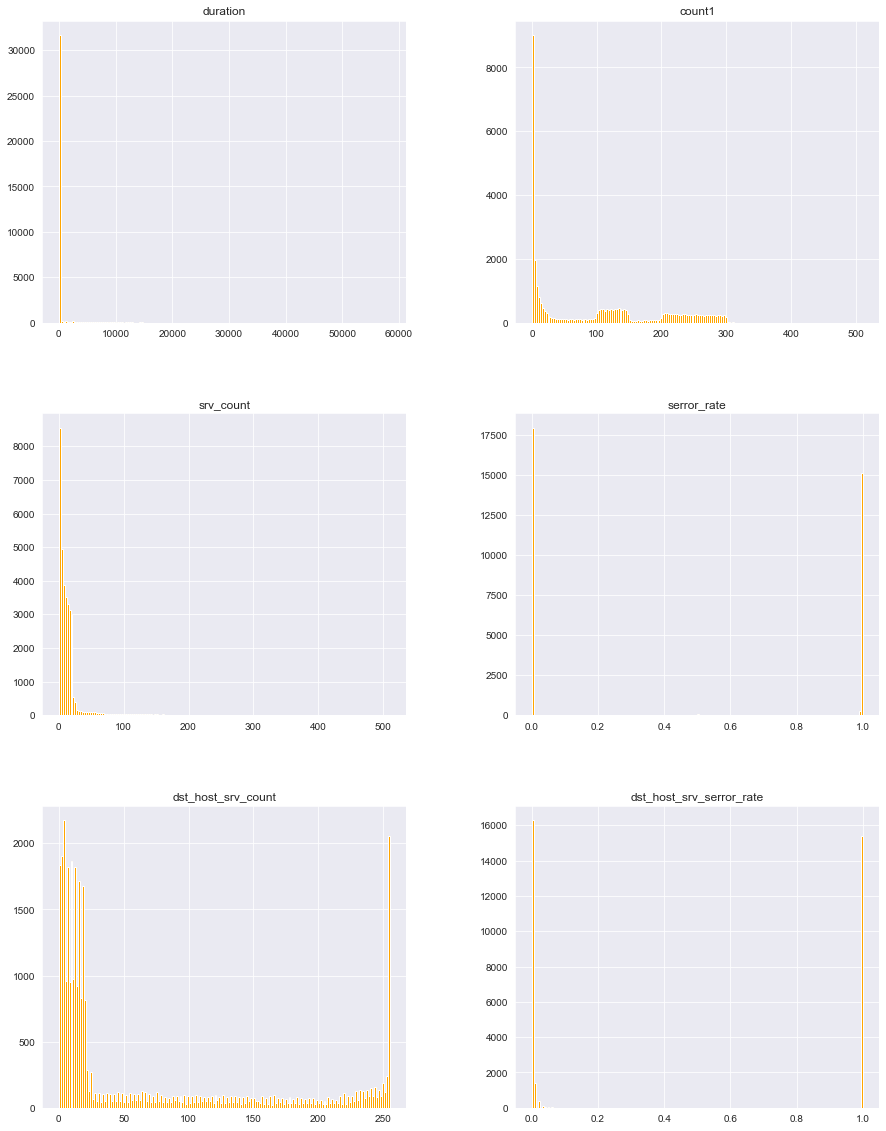

In [123]:
""" Mostrad un histograma por cada variable numérica """
# codigo-alumno
pd_data1[num_cols] = pd_data1[num_cols].astype(float)
pd_data1[num_cols].hist( bins=170,figsize=(15,20),color='orange')

plt.show

In [124]:
pd_data1.describe()

,duration,count1,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
count,33869.000000,33869.000000,33869.000000,33869.000000,33869.000000,33869.000000,33869.000000
mean,356.226166,99.158818,15.013641,0.459215,66.860964,0.458115,0.527916
std,1871.233848,100.740942,30.839906,0.496742,87.285937,0.496752,0.499227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,0.000000,7.000000,0.000000,0.000000
50%,0.000000,80.000000,8.000000,0.000000,16.000000,0.010000,1.000000
75%,0.000000,193.000000,16.000000,1.000000,114.000000,1.000000,1.000000
max,58329.000000,511.000000,510.000000,1.000000,255.000000,1.000000,1.000000


##### Variable: Duration

<function matplotlib.pyplot.show(close=None, block=None)>

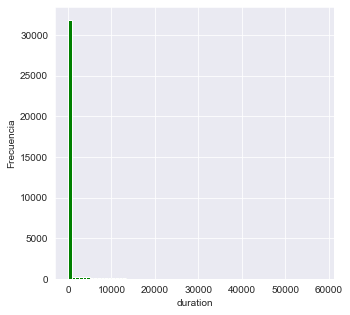

In [125]:
pd_data1['duration'].hist( bins=70,figsize=(5,5),color='green')
plt.xlabel("duration")
plt.ylabel("Frecuencia")
plt.show

In [126]:
pd_data1.groupby('duration').size().sort_values(ascending=False)

duration
0.0        28024
1.0          620
2.0          418
3.0          305
4.0          238
           ...  
2547.0         1
2545.0         1
2543.0         1
2538.0         1
58329.0        1
Length: 2147, dtype: int64

In [127]:
pd_data1['duration'] = pd_data1.duration.apply(lambda x: 0 if x==0 else x)# codigo-alumno
pd_data1['duration'] = pd_data1.duration.apply(lambda x: 1 if (x>0)&(x<20) else x)# codigo-alumno
pd_data1['duration'] = pd_data1.duration.apply(lambda x: 2 if x>=20 else x)# codigo-alumno

In [128]:
pd_data1.groupby('duration').size().sort_values(ascending=False)

duration
0.0    28024
2.0     3157
1.0     2688
dtype: int64

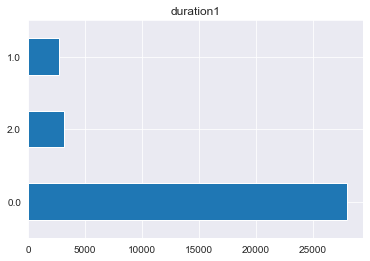

In [129]:
plot = pd_data1['duration'].value_counts().plot(kind='barh',
                                            title='duration1')

##### Variable: srv_count

<function matplotlib.pyplot.show(close=None, block=None)>

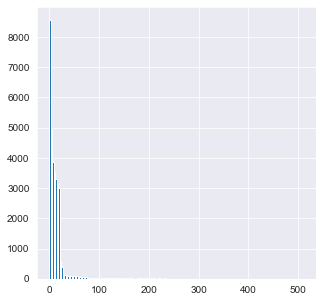

In [130]:
pd_data1['srv_count'].hist( bins=170,figsize=(5,5))

plt.show

In [131]:
pd_data1.groupby('srv_count').size().sort_values(ascending=False)

srv_count
1.0      5062
2.0      3497
3.0      1979
4.0      1577
5.0      1402
         ... 
294.0       1
301.0       1
303.0       1
304.0       1
510.0       1
Length: 314, dtype: int64

In [132]:
#Sacamos los cuartiles que vamos a usar como umbrales de las categorías
pd_data1['srv_count'].quantile([.25, .5, .75])

0.25     2.0
0.50     8.0
0.75    16.0
Name: srv_count, dtype: float64

In [133]:
pd_data1['srv_count'] = pd_data1.srv_count.apply(lambda x: 0 if x<2.0 else x)# codigo-alumno
pd_data1['srv_count'] = pd_data1.srv_count.apply(lambda x: 1 if (x>=2.0)&(x<8) else x)# codigo-alumno
pd_data1['srv_count'] = pd_data1.srv_count.apply(lambda x: 2 if (x>=8)&(x<16) else x)# codigo-alumno
pd_data1['srv_count'] = pd_data1.srv_count.apply(lambda x: 3 if x>=16 else x)# codigo-alumno
pd_data1.groupby('srv_count').size().sort_values(ascending=False)

srv_count
1.0    11051
2.0     9190
3.0     8565
0.0     5063
dtype: int64

Esto ha sido otra opción de umbrales que se ha descartado por no estár basado más que en la observación de los plots, pero no en índices estadísticos.

`#pd_data1['srv_count1'] = pd_data1.srv_count.apply(lambda x: 0 if x<=3 else x)
#pd_data1['srv_count1'] = pd_data1.srv_count.apply(lambda x: 1 if (x>3)&(x<12) else x)
#pd_data1['srv_count1'] = pd_data1.srv_count.apply(lambda x: 2 if x>=12.0 else x)`


In [134]:
pd_data1.groupby('srv_count').size().sort_values(ascending=False)

srv_count
1.0    11051
2.0     9190
3.0     8565
0.0     5063
dtype: int64

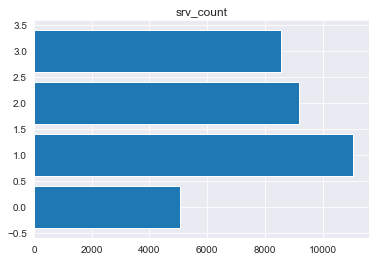

In [135]:
# codigo-alumno
k = pd_data1.groupby('srv_count').size()
plt.barh(k.index, k)
plt.title('srv_count')
plt.ylabel
plt.show()

##### Variable: serror_rate

<function matplotlib.pyplot.show(close=None, block=None)>

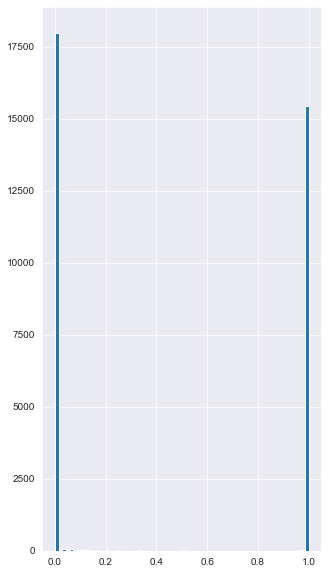

In [136]:
pd_data1['serror_rate'].hist( bins=70,figsize=(5,10))

plt.show

In [137]:
pd_data1.groupby('serror_rate').size().sort_values(ascending=False)

serror_rate
0.00    17975
1.00    15135
0.99      292
0.50       44
0.06       34
0.03       30
0.04       29
0.07       29
0.08       29
0.25       26
0.05       25
0.33       24
0.17       24
0.20       19
0.98       17
0.11       15
0.09       13
0.10       12
0.14       11
0.12       11
0.02       10
0.97        9
0.96        7
0.95        5
0.94        5
0.85        3
0.93        2
0.88        2
0.83        2
0.86        2
0.84        2
0.60        2
0.22        2
0.64        2
0.62        2
0.66        1
0.92        1
0.19        1
0.38        1
0.53        1
0.55        1
0.57        1
0.58        1
0.01        1
0.91        1
0.67        1
0.63        1
0.65        1
0.82        1
0.81        1
0.79        1
0.78        1
0.59        1
dtype: int64

In [138]:
pd_data1['serror_rate'] = pd_data1.serror_rate.apply(lambda x: 0 if x==0.0 else 1)# codigo-alumno
pd_data1['serror_rate'] = pd_data1.serror_rate.apply(lambda x: 1 if x>=1.0 else x)# codigo-alumno
pd_data1['serror_rate'] = pd_data1.serror_rate.apply(lambda x: 2 if (x>0.0)&(x<1.0) else x)# codigo-alumno


In [139]:
pd_data1.groupby('serror_rate').size().sort_values(ascending=False)

serror_rate
0    17975
1    15894
dtype: int64

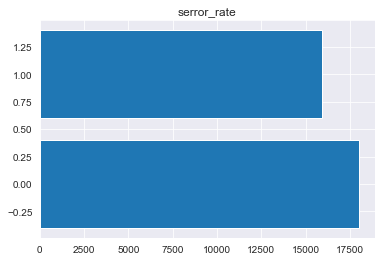

In [140]:
# codigo-alumno
k = pd_data1.groupby('serror_rate').size()
plt.barh(k.index, k)
plt.title('serror_rate')
plt.ylabel
plt.show()

##### Variable: count

Esta variable ya fue renombrada

<function matplotlib.pyplot.show(close=None, block=None)>

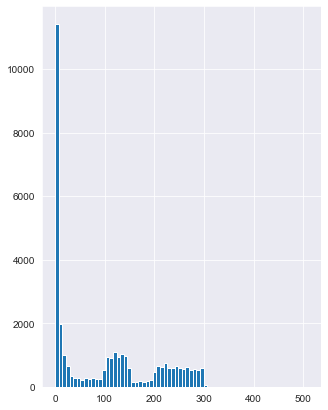

In [141]:
pd_data1['count1'].hist( bins=70,figsize=(5,7))

plt.show

In [142]:
pd_data1.groupby('count1').size().sort_values(ascending=False)

count1
1.0      6212
2.0      1991
4.0       833
3.0       814
5.0       606
         ... 
313.0       1
312.0       1
305.0       1
304.0       1
511.0       1
Length: 337, dtype: int64

In [143]:
pd_data1['count1'].quantile([.25, .5, .75])

0.25      3.0
0.50     80.0
0.75    193.0
Name: count1, dtype: float64

In [144]:
pd_data1['count1'] = pd_data1.count1.apply(lambda x: 0 if x<2.0 else x)# codigo-alumno
pd_data1['count1'] = pd_data1.count1.apply(lambda x: 1 if (x>=2.0)&(x<60) else x)# codigo-alumno
pd_data1['count1'] = pd_data1.count1.apply(lambda x: 2 if (x>=60)&(x<181) else x)# codigo-alumno
pd_data1['count1'] = pd_data1.count1.apply(lambda x: 3 if x>=181 else x)# codigo-alumno
pd_data1.groupby('count1').size().sort_values(ascending=False)

count1
1.0    9998
2.0    8854
3.0    8804
0.0    6213
dtype: int64

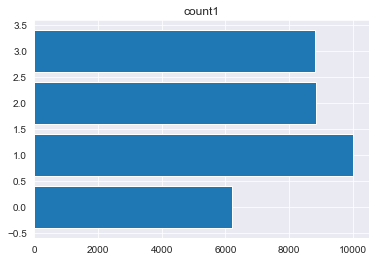

In [145]:
# codigo-alumno
k = pd_data1.groupby('count1').size()
plt.barh(k.index, k)
plt.title('count1')
plt.ylabel
plt.show()

##### Variable: dst_host_srv_count

<function matplotlib.pyplot.show(close=None, block=None)>

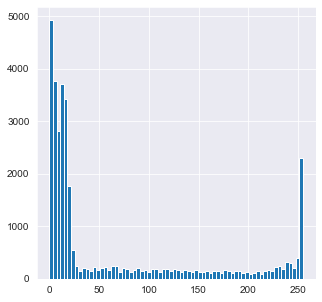

In [146]:
pd_data1['dst_host_srv_count'].hist( bins=70,figsize=(5,5))

plt.show

In [147]:
pd_data1.groupby('dst_host_srv_count').size().sort_values(ascending=False)

dst_host_srv_count
2.0      1902
1.0      1835
255.0    1626
3.0      1190
4.0       985
         ... 
154.0      24
202.0      24
164.0      23
204.0      21
0.0         1
Length: 256, dtype: int64

In [148]:
pd_data1['dst_host_srv_count'].quantile([.25, .5, .75])

0.25      7.0
0.50     16.0
0.75    114.0
Name: dst_host_srv_count, dtype: float64

In [149]:
pd_data1['dst_host_srv_count'] = pd_data1.dst_host_srv_count.apply(lambda x: 0 if x < 7 else x)# codigo-alumno
pd_data1['dst_host_srv_count'] = pd_data1.dst_host_srv_count.apply(lambda x: 1 if (x >= 7)&(x<17) else x)# codigo-alumno
pd_data1['dst_host_srv_count'] = pd_data1.dst_host_srv_count.apply(lambda x: 2 if (x >= 17)&(x<116) else x)# codigo-alumno
pd_data1['dst_host_srv_count'] = pd_data1.dst_host_srv_count.apply(lambda x: 3 if x >= 116 else x)# codigo-alumno

pd_data1.groupby('dst_host_srv_count').size().sort_values(ascending=False)

dst_host_srv_count
1.0    9157
2.0    8513
3.0    8412
0.0    7787
dtype: int64

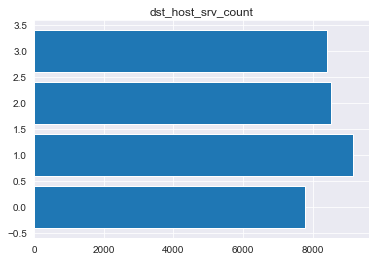

In [150]:
# codigo-alumno
k = pd_data1.groupby('dst_host_srv_count').size()
plt.barh(k.index, k)
plt.title('dst_host_srv_count')
plt.ylabel
plt.show()

##### Variable: dst_host_srv_serror_rate

<function matplotlib.pyplot.show(close=None, block=None)>

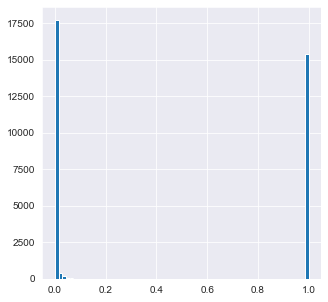

In [151]:
pd_data1['dst_host_srv_serror_rate'].hist( bins=70,figsize=(5,5))

plt.show

In [152]:
pd_data1.groupby('dst_host_srv_serror_rate').size().sort_values(ascending=False)

dst_host_srv_serror_rate
0.00    16292
1.00    15411
0.01     1419
0.02      378
0.03      103
        ...  
0.66        1
0.64        1
0.56        1
0.62        1
0.52        1
Length: 70, dtype: int64

In [153]:
pd_data1['dst_host_srv_serror_rate'] = pd_data1.dst_host_srv_serror_rate.apply(lambda x: 0 if x == 0.00 else x)# codigo-alumno
pd_data1['dst_host_srv_serror_rate'] = pd_data1.dst_host_srv_serror_rate.apply(lambda x: 1 if x == 1.00 else x)# codigo-alumno
pd_data1['dst_host_srv_serror_rate'] = pd_data1.dst_host_srv_serror_rate.apply(lambda x: 2 if (x>0.00)&(x<1.00) else x)# codigo-alumno

pd_data1.groupby('dst_host_srv_serror_rate').size().sort_values(ascending=False)

dst_host_srv_serror_rate
0.0    16292
1.0    15411
2.0     2166
dtype: int64

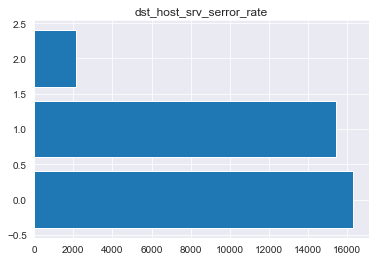

In [154]:
# codigo-alumno
k = pd_data1.groupby('dst_host_srv_serror_rate').size()
plt.barh(k.index, k)
plt.title('dst_host_srv_serror_rate')
plt.ylabel
plt.show()

#### Analysys categorical variables 

In [155]:
#Decode all variables to eliminate troubles with their labels code

pd_data1['service'] = pd_data1.service.str.decode('utf-8')
pd_data1['flag'] = pd_data1.flag.str.decode('utf-8')
pd_data1['protocol_type'] = pd_data1.protocol_type.str.decode('utf-8')

##### Service 

In [156]:
""" Transformad la variable service en una variable dummy que nos permitan identificar el servicio
    más frecuente frente al resto """

' Transformad la variable service en una variable dummy que nos permitan identificar el servicio\n    más frecuente frente al resto '

In [157]:
pd_data1.groupby('service').size().sort_values(ascending=False)

service
private     12604
http         4588
smtp         3122
domain_u     3114
other        2279
            ...  
urh_i          11
X11             9
tim_i           2
red_i           1
tftp_u          1
Length: 65, dtype: int64

In [158]:
# codigo-alumno
pd_data1['service'] = pd_data1.service.apply(lambda x: 1 if x == 'private' else 0)# codigo-alumno
pd_data1.groupby('service').size().sort_values(ascending=False)

service
0    21265
1    12604
dtype: int64

##### Flag 

In [159]:
""" Transformad la variable flag en dos variables dummy que nos permitan identificar 3 tipos de flags, 
    los dos más comunes y el resto """

' Transformad la variable flag en dos variables dummy que nos permitan identificar 3 tipos de flags, \n    los dos más comunes y el resto '

In [160]:
pd_data1.groupby('flag').size().sort_values(ascending=False)

flag
S0      15499
SF      15470
REJ      2322
RSTO      476
S1         48
RSTR       31
S2         15
S3          7
OTH         1
dtype: int64

In [161]:
pd_data1['flag'] = pd_data1.flag.apply(lambda x: 0 if x == 'S0' else x)# codigo-alumno
pd_data1['flag'] = pd_data1.flag.apply(lambda x: 1 if x == 'SF' else x)# codigo-alumno
pd_data1['flag'] = pd_data1.flag.apply(lambda x: 2 if (x !=0)&(x!=1) else x)# codigo-alumno
pd_data1.groupby('flag').size().sort_values(ascending=False)

flag
0    15499
1    15470
2     2900
dtype: int64

##### logged_in

In [162]:
#De momento sólo cambiar el tipo de datos
pd_data1[['logged_in']].astype(float)

,logged_in
3,1.0
8,1.0
9,1.0
10,1.0
13,1.0
...,...
493920,1.0
493927,1.0
493967,1.0
494001,0.0


##### protocol_type

In [163]:
#De momento no se hace nadam se hará en etapas posteriores

### Datasets analyzed

Se ha partido de un dataset denominado pd_data. Se ha creado una copia llamada pd_data1 que es la que se ha usado para hacer el análsis de las variables. 
- pd_data1 = contiene las variables numéricas todas transformadas a categóricas

#### Original: pd_data   =>Dataset con variables originales

In [164]:
pd_data.head()

,duration,protocol_type,service,flag,logged_in,count1,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
3,0.0,b'tcp',b'http',b'SF',1,6.0,6.0,0.0,39.0,0.0,0
8,0.0,b'tcp',b'http',b'SF',1,8.0,8.0,0.0,89.0,0.0,0
9,0.0,b'tcp',b'http',b'SF',1,8.0,8.0,0.0,99.0,0.0,0
10,0.0,b'tcp',b'http',b'SF',1,18.0,18.0,0.0,109.0,0.0,0
13,0.0,b'tcp',b'http',b'SF',1,4.0,4.0,0.0,139.0,0.0,0


#### A-option: pd_data1   => Dataset siguiendo el ejercico dado, todas variables numéricas pasadas a categóricas

In [165]:
pd_data1.head()

,duration,protocol_type,service,flag,logged_in,count1,srv_count,serror_rate,dst_host_srv_count,dst_host_srv_serror_rate,labels
3,0.0,tcp,0,1,1,1.0,1.0,0,2.0,0.0,0
8,0.0,tcp,0,1,1,1.0,2.0,0,2.0,0.0,0
9,0.0,tcp,0,1,1,1.0,2.0,0,2.0,0.0,0
10,0.0,tcp,0,1,1,1.0,3.0,0,2.0,0.0,0
13,0.0,tcp,0,1,1,1.0,1.0,0,3.0,0.0,0


In [166]:
pd_data1['logged_in']
pd_data1.groupby('logged_in').size().sort_values(ascending=False)

logged_in
0    25032
1     8837
dtype: int64

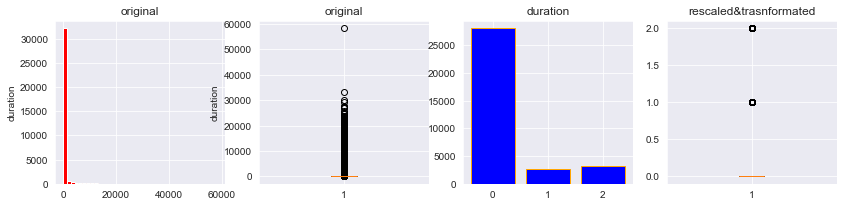

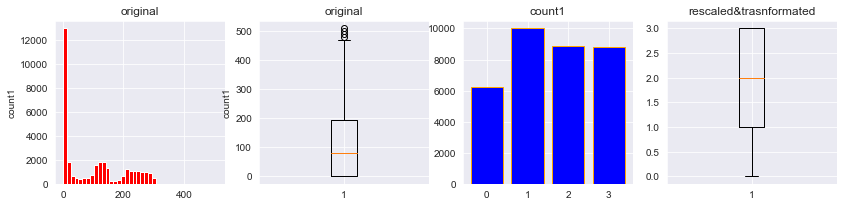

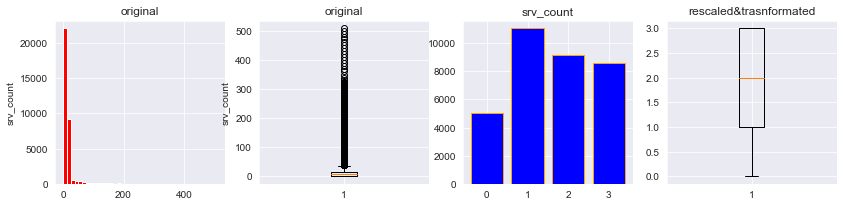

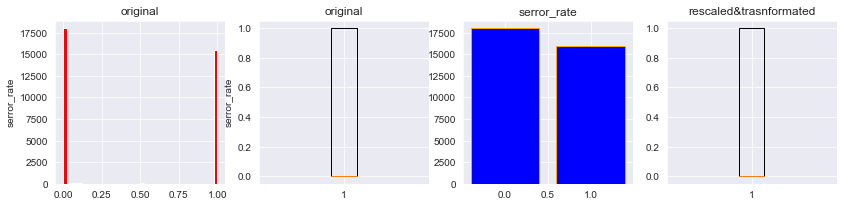

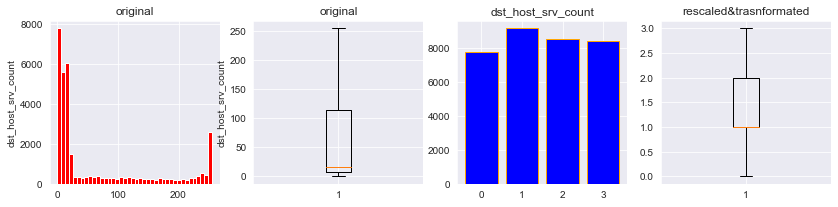

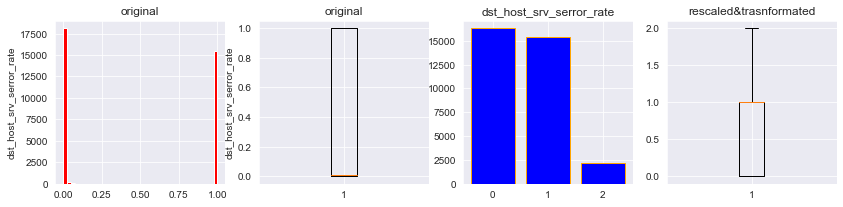

In [167]:

#Visualización de las trasnformaciones realizadas en variables numéricas guardadas en pd_data1

cols = ['duration', 'count1', 'srv_count', 'serror_rate', 'dst_host_srv_count', 'dst_host_srv_serror_rate']

for col in cols:
    plot_0 = pd_data[[col]]
    plot_1 = pd_data1[[col]]
    plt.figure(figsize=(14,3))
    plt.subplot(1,4,1)
    plt.title('original')
    plt.ylabel(col)
    plt.hist(plot_0, bins=40,color='red')
    plt.subplot(1,4,2)
    plt.title('original')
    plt.ylabel(col)
    plt.boxplot(plot_0)
    plt.subplot(1,4,3)
    plt.title('rescaled&trasnformated')
    k = pd_data1.groupby(col).size()
    plt.bar(k.index, k,color='blue',edgecolor='orange')
    plt.title(col)
    plt.ylabel
    plt.subplot(1,4,4)
    plt.title('rescaled&trasnformated')
    plt.boxplot(plot_1)
    plt.show()

# Analsys dataset : pd_data1

### Get dummies from numeric variables 

Por la forma de los histogramas, podría ser un buen estudio convertir las variables
    numéricas a variables dummy, es lo que hareis en este apartado y, por tanto, pasarán 
    a ser categóricas todas las variables del dataframe. Esta parte será libre para el 
    estudiante. Deberá tomar la decisión que considere más apropiada para realizar esta 
    binarización



In [168]:
pd_data1.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'logged_in', 'count1',
       'srv_count', 'serror_rate', 'dst_host_srv_count',
       'dst_host_srv_serror_rate', 'labels'],
      dtype='object')

In [169]:
key_cols_dummies = ['duration', 'count1',
       'srv_count', 'serror_rate', 'dst_host_srv_count',
       'dst_host_srv_serror_rate']
                                             
pd_data1 = pd.get_dummies(pd_data1, columns= key_cols_dummies,drop_first=True)

In [170]:
pd_data1.head()

,protocol_type,service,flag,logged_in,labels,duration_1.0,duration_2.0,count1_1.0,count1_2.0,count1_3.0,srv_count_1.0,srv_count_2.0,srv_count_3.0,serror_rate_1,dst_host_srv_count_1.0,dst_host_srv_count_2.0,dst_host_srv_count_3.0,dst_host_srv_serror_rate_1.0,dst_host_srv_serror_rate_2.0
3,tcp,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
8,tcp,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
9,tcp,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
10,tcp,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0
13,tcp,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [171]:
pd_data1.columns

Index(['protocol_type', 'service', 'flag', 'logged_in', 'labels',
       'duration_1.0', 'duration_2.0', 'count1_1.0', 'count1_2.0',
       'count1_3.0', 'srv_count_1.0', 'srv_count_2.0', 'srv_count_3.0',
       'serror_rate_1', 'dst_host_srv_count_1.0', 'dst_host_srv_count_2.0',
       'dst_host_srv_count_3.0', 'dst_host_srv_serror_rate_1.0',
       'dst_host_srv_serror_rate_2.0'],
      dtype='object')

### Barplot por cada variable 


Volved a mostrad un barplot por cada variable


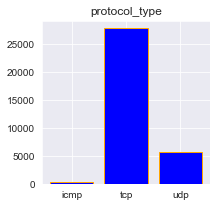

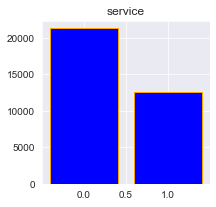

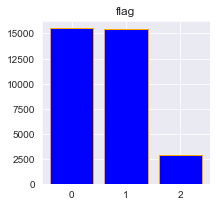

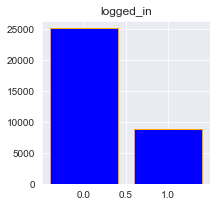

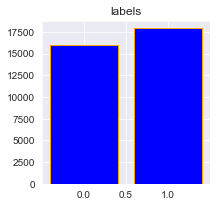

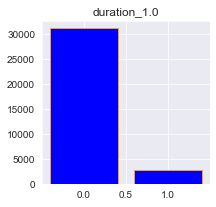

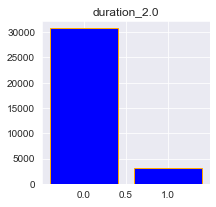

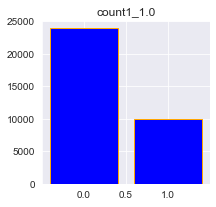

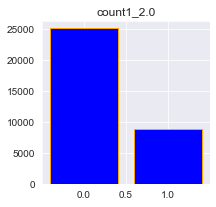

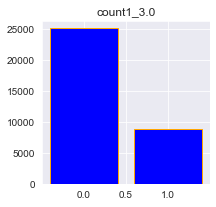

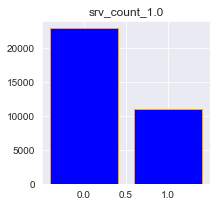

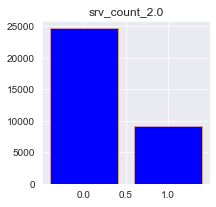

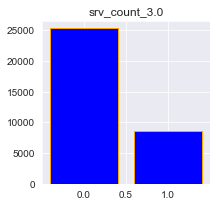

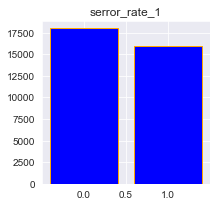

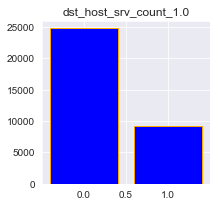

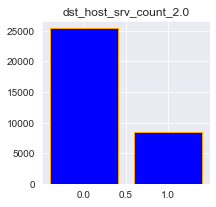

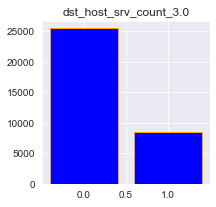

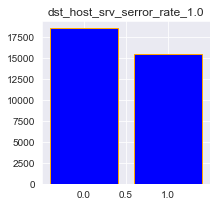

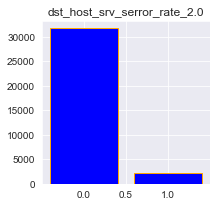

In [172]:
cols_pd_data1 = ['protocol_type', 'service', 'flag', 'logged_in', 'labels',
       'duration_1.0', 'duration_2.0', 'count1_1.0', 'count1_2.0',
       'count1_3.0', 'srv_count_1.0', 'srv_count_2.0', 'srv_count_3.0',
       'serror_rate_1', 'dst_host_srv_count_1.0', 'dst_host_srv_count_2.0',
       'dst_host_srv_count_3.0', 'dst_host_srv_serror_rate_1.0',
       'dst_host_srv_serror_rate_2.0']

for col in cols_pd_data1:
    k = pd_data1.groupby(col).size()
    plt.figure(figsize=(3,3))
    plt.bar(k.index, k,color='blue',edgecolor='orange')
    plt.title(col)
    plt.ylabel
    plt.show()
    #sns.countplot(data=pd_data3,x=col)
    #plt.show()
    #plot = pd_data[col].value_counts().plot(kind='barh',
                                            #title=col)

### Correlation variables analisys

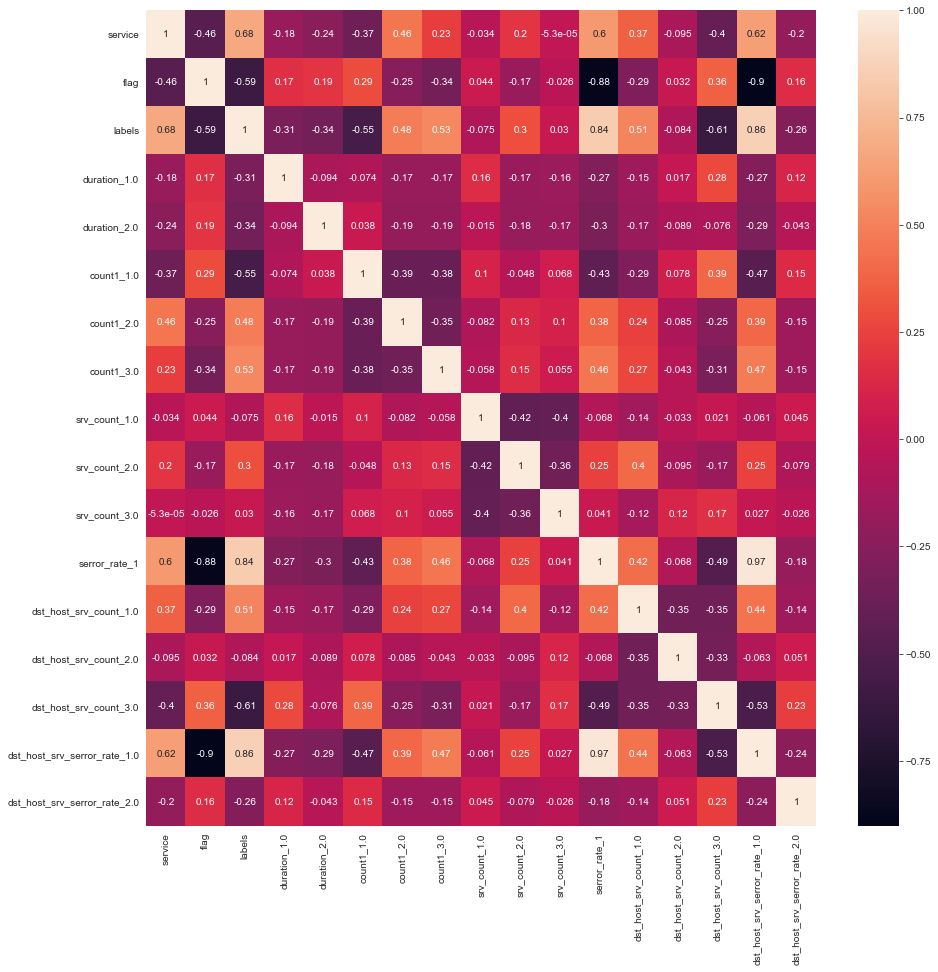

In [173]:
""" Mostrad un plot de correlaciones entre variables numéricas """

# codigo-alumno
plt.figure(figsize=(15,15))
sns.heatmap(pd_data1.corr(), annot=True)
plt.show()

In [174]:
len(pd_data1)

33869

In [175]:
#Se comprueba si hay registros duplicados en las variables
print('el número de duplicados es', pd_data1.duplicated().sum())

# length initial
length1=  len(pd_data1)

# dropping duplicate values
pd_data1.drop_duplicates(keep=False, inplace=True)
 
# length after removing duplicates
length2=len(pd_data1)
 
# printing all data frame lengths
print('el tamaño inicial del dataframe es',length1,'y el tamaño despues de quitar duplicados es',length2)




el número de duplicados es 33349
el tamaño inicial del dataframe es 33869 y el tamaño despues de quitar duplicados es 115


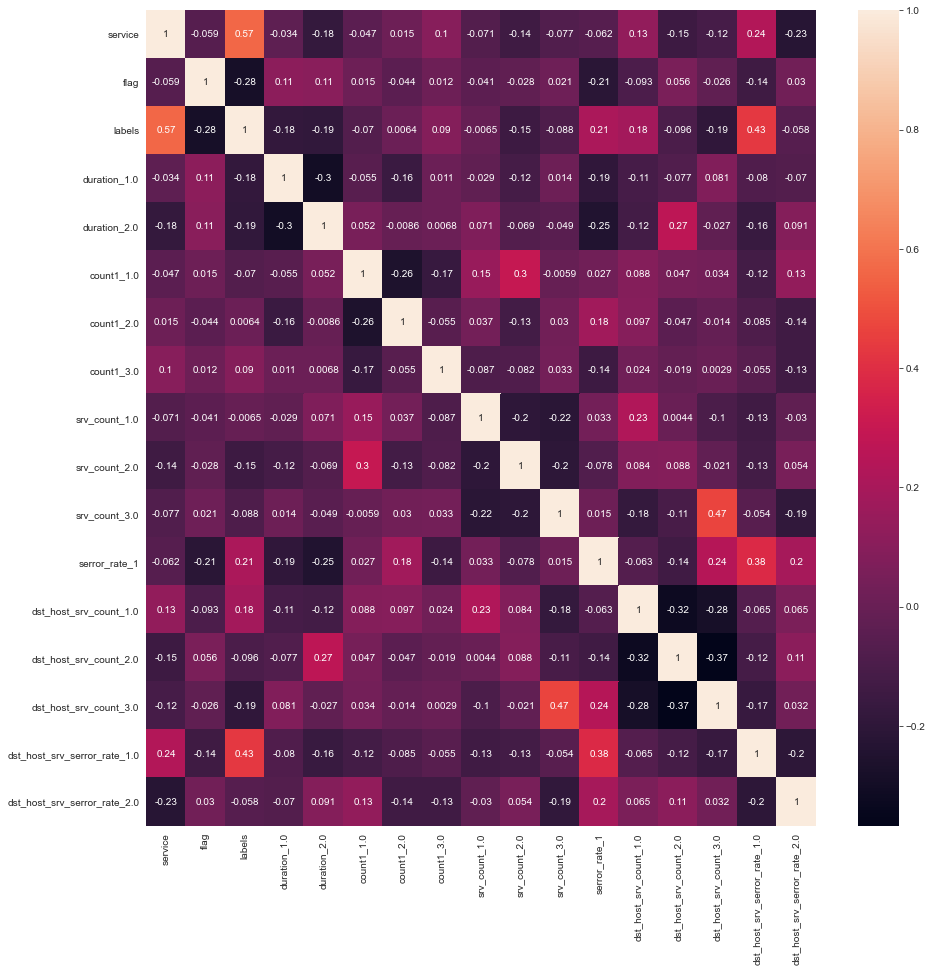

In [176]:
#Volvemos a calcular la matriz de correlaciones, para ver cómo están en el dataframe previo a las transformaciones y modelización.
# codigo-alumno
plt.figure(figsize=(15,15))
sns.heatmap(pd_data1.corr(), annot=True)
plt.show()

In [177]:
pd_data1.corr().style.background_gradient('coolwarm')#mejora la posibilidad de ver las relaciones


,service,flag,labels,duration_1.0,duration_2.0,count1_1.0,count1_2.0,count1_3.0,srv_count_1.0,srv_count_2.0,srv_count_3.0,serror_rate_1,dst_host_srv_count_1.0,dst_host_srv_count_2.0,dst_host_srv_count_3.0,dst_host_srv_serror_rate_1.0,dst_host_srv_serror_rate_2.0
service,1.000000,-0.058690,0.565969,-0.034419,-0.180144,-0.046675,0.015316,0.099622,-0.071220,-0.140097,-0.077192,-0.062472,0.133045,-0.145917,-0.115613,0.235477,-0.228468
flag,-0.058690,1.000000,-0.283455,0.113829,0.105774,0.015190,-0.043565,0.012013,-0.041262,-0.027739,0.021290,-0.214861,-0.093259,0.055597,-0.026183,-0.142773,0.030294
labels,0.565969,-0.283455,1.000000,-0.184486,-0.189066,-0.069852,0.006446,0.090443,-0.006526,-0.147036,-0.087708,0.213697,0.184886,-0.096478,-0.193638,0.430064,-0.058368
duration_1.0,-0.034419,0.113829,-0.184486,1.000000,-0.299387,-0.054698,-0.157493,0.010852,-0.028615,-0.118406,0.013569,-0.194099,-0.114335,-0.076849,0.080869,-0.080092,-0.070329
duration_2.0,-0.180144,0.105774,-0.189066,-0.299387,1.000000,0.052180,-0.008635,0.006815,0.070598,-0.069227,-0.049407,-0.249718,-0.123091,0.270521,-0.027434,-0.161402,0.090644
count1_1.0,-0.046675,0.015190,-0.069852,-0.054698,0.052180,1.000000,-0.255562,-0.166493,0.152920,0.298054,-0.005922,0.026927,0.087706,0.046796,0.033763,-0.124942,0.129712
count1_2.0,0.015316,-0.043565,0.006446,-0.157493,-0.008635,-0.255562,1.000000,-0.055314,0.037138,-0.125522,0.029877,0.182429,0.097129,-0.046888,-0.014431,-0.084906,-0.135867
count1_3.0,0.099622,0.012013,0.090443,0.010852,0.006815,-0.166493,-0.055314,1.000000,-0.087101,-0.081775,0.033113,-0.143990,0.023729,-0.018991,0.002885,-0.055314,-0.133357
srv_count_1.0,-0.071220,-0.041262,-0.006526,-0.028615,0.070598,0.152920,0.037138,-0.087101,1.000000,-0.197653,-0.216870,0.033146,0.229416,0.004372,-0.099936,-0.133697,-0.029688
srv_count_2.0,-0.140097,-0.027739,-0.147036,-0.118406,-0.069227,0.298054,-0.125522,-0.081775,-0.197653,1.000000,-0.203609,-0.078229,0.083762,0.088014,-0.021335,-0.125522,0.053534


In [178]:
pd_data1

,protocol_type,service,flag,logged_in,labels,duration_1.0,duration_2.0,count1_1.0,count1_2.0,count1_3.0,srv_count_1.0,srv_count_2.0,srv_count_3.0,serror_rate_1,dst_host_srv_count_1.0,dst_host_srv_count_2.0,dst_host_srv_count_3.0,dst_host_srv_serror_rate_1.0,dst_host_srv_serror_rate_2.0
7637,tcp,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
16064,tcp,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
22839,tcp,0,1,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,1
22955,udp,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
26757,tcp,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486863,tcp,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
486900,tcp,0,2,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1
491015,icmp,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
491360,udp,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0


## Preprocessing

In [179]:
"""Realizaré un ColumnTransformer que lleve:

- Un OneHotEncoder para las variables: 'protocol_type','logged_in'
"""
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

cat_ftrs_OHE = ['protocol_type', 'logged_in']


col_transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_ftrs_OHE)
    ],remainder='passthrough'
)
#col_transformer.named_transformers_
#encoded_cat = col_transformer.named_transformers_['cat'].get_feature_names(cat_ftrs_OHE)
#labels = np.concatenate([ftrs_for_imputing, encoded_cat])

ctransformed = col_transformer.fit_transform(pd_data1)
ctransformed


#get_feature_names()
#encoded_cat = col_transformer.named_transformers_['cat'].get_feature_names(cat_ftrs_OHE)
#labels = np.concatenate([ftrs_for_imputing, encoded_cat])
#datos_train_prep = preprocessor.transform(X_train)
#datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
#datos_train_prep.info()

encoded=col_transformer.get_feature_names()
pdtransformed = pd.DataFrame(ctransformed,columns=encoded)
pdtransformed

,cat__x0_icmp,cat__x0_tcp,cat__x0_udp,cat__x1_0,cat__x1_1,service,flag,labels,duration_1.0,duration_2.0,...,count1_3.0,srv_count_1.0,srv_count_2.0,srv_count_3.0,serror_rate_1,dst_host_srv_count_1.0,dst_host_srv_count_2.0,dst_host_srv_count_3.0,dst_host_srv_serror_rate_1.0,dst_host_srv_serror_rate_2.0
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
111,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
112,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Model validation

##### Split variables target and imput 

In [180]:
""" Realizad una evaluación de, al menos, cinco modelos de machine learning con
    la técnica de validación cruzada más acertada (10 splits). Además, se pide
    incorporar, al menos, una técnica de selección previa de las 1, 2 o 3 features que
    mejores resultados ofrezca (Nota, tendreis que usar OneHotEncoder para las variables 
    que tengan strings) """

target = 'labels'
X = pd_data1.drop(target, axis=1) 
y = pd_data1[target]



### Pipeline1: (OHE+Powertransformer+Algorithms+kfold)

In [181]:
#algorithms
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC()))
models.append(('LR', SVC()))



In [182]:
""" Para plotear los resultados utilizaremos la siguiente función """

def boxplots_algorithms(results, names):
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

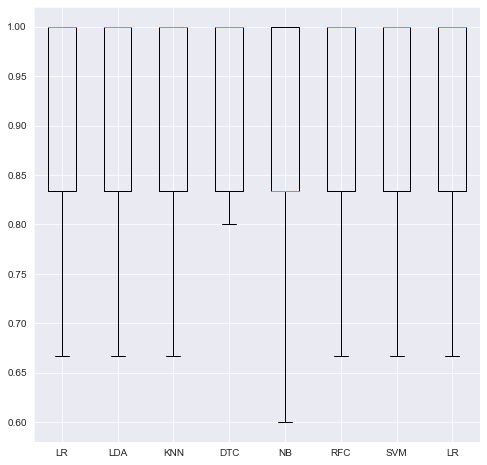

,algorithm,mean_pipeline1,std_pipeline1
0,LR,0.915000,0.100264
1,LDA,0.923333,0.100056
2,KNN,0.923333,0.100056
3,DTC,0.948333,0.079215
4,NB,0.878333,0.115121
5,RFC,0.941667,0.095379
6,SVM,0.923333,0.100056
7,LR,0.923333,0.100056


In [183]:
#Pipeline1:Columntransformer + OHE + Powertransformer + model
results_1 = []
names = []

for name, model in models:
    transformer = col_transformer
    scaler = PowerTransformer(method='yeo-johnson')
    pipeline1 = make_pipeline(transformer, scaler,model)
    
    cv_technique = KFold(n_splits=20, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline1, X,y,cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   
    
    results_1.append(cv_results)
    names.append(name)
    

    
boxplots_algorithms(results_1, names)

results1 = pd.DataFrame(results_1)
results1['mean_pipeline1']=results1.mean(axis=1)
results1['std_pipeline1']=results1.std(axis=1)
results1['algorithm']=names
key_columns_r=['algorithm','mean_pipeline1','std_pipeline1']
results1 = results1[key_columns_r]  
results1
    

In [184]:

set_config(display='diagram')
pipeline1

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('powertransformer', PowerTransformer()), ('svc', SVC())])

### Pipeline2: (OHE+RobustScaler+Algorithms)

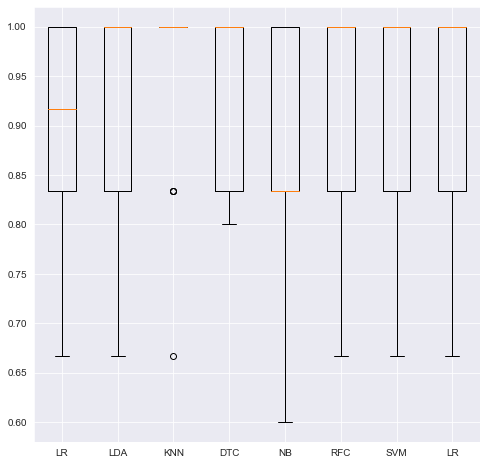

,algorithm,mean_pipeline2,std_pipeline2
0,LR,0.906667,0.099778
1,LDA,0.923333,0.100056
2,KNN,0.958333,0.089365
3,DTC,0.948333,0.079215
4,NB,0.878333,0.115121
5,RFC,0.941667,0.095379
6,SVM,0.925000,0.111492
7,LR,0.925000,0.111492


In [185]:
#Pipeline2:ColumnTransformer + OHE + MinMaxScaler + model
results_2 = []
names = []

for name, model in models:
    transformer = col_transformer
    scaler =RobustScaler()
    pipeline2 = make_pipeline(transformer, scaler,model)
    
    cv_technique = KFold(n_splits=20, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline2, X,y,cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    results_2.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results_2, names)


results2 = pd.DataFrame(results_2)
results2['mean_pipeline2']=results2.mean(axis=1)
results2['std_pipeline2']=results2.std(axis=1)
results2['algorithm']=names
key_columns_r=['algorithm','mean_pipeline2','std_pipeline2']
results2 = results2[key_columns_r]  
results2
    

In [186]:
set_config(display='diagram')
pipeline2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('robustscaler', RobustScaler()), ('svc', SVC())])

### Pipeline3: (OHE+Normalizer+Algorithms)

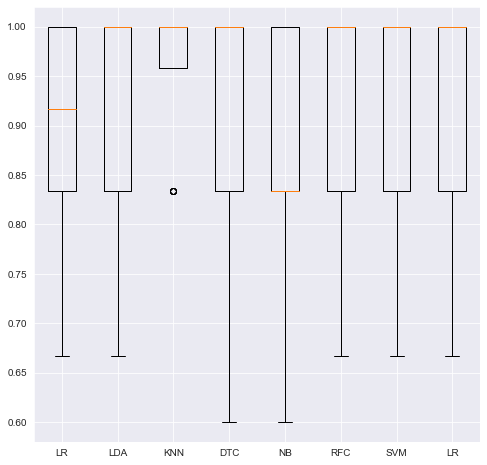

,algorithm,mean_pipeline3,std_pipeline3
0,LR,0.898333,0.111791
1,LDA,0.925000,0.111492
2,KNN,0.958333,0.072169
3,DTC,0.903333,0.120600
4,NB,0.878333,0.115121
5,RFC,0.931667,0.112287
6,SVM,0.925000,0.111492
7,LR,0.925000,0.111492


In [187]:
#Pipeline3:ColumnTransformer + OHE + RobustScaler + model
results_3 = []
names = []

for name, model in models:
    transformer = col_transformer
    scaler =Normalizer()
    pipeline3 = make_pipeline(transformer, scaler,model)
    
    cv_technique = KFold(n_splits=20, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline3, X,y,cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
    results_3.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results_3, names)


results3 = pd.DataFrame(results_3)
results3['mean_pipeline3']=results3.mean(axis=1)
results3['std_pipeline3']=results3.std(axis=1)
results3['algorithm']=names
key_columns_r=['algorithm','mean_pipeline3','std_pipeline3']
results3 = results3[key_columns_r]  
results3
    
    
    
    

In [188]:
set_config(display='diagram')
pipeline3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('normalizer', Normalizer()), ('svc', SVC())])

## Model validation & Feature selection 

### Pipeline4: (OHE+RobustScaler+SelectKBest(f_classif)+Algorithms)

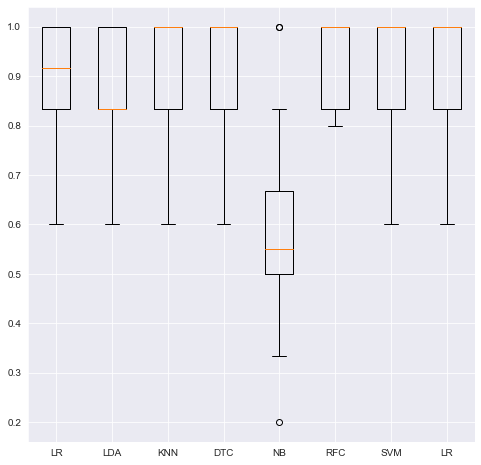

,algorithm,mean_pipeline4,std_pipeline4
0,LR,0.896667,0.118275
1,LDA,0.876667,0.132119
2,KNN,0.901667,0.137224
3,DTC,0.921667,0.119849
4,NB,0.593333,0.202100
5,RFC,0.940000,0.082057
6,SVM,0.921667,0.119849
7,LR,0.921667,0.119849


In [189]:
#Pipeline4:Columntransformer + OHE + Powertransformer + model
results_4 = []
names = []

for name, model in models:
    transformer = col_transformer
    scaler = PowerTransformer(method='yeo-johnson')
    selector = SelectKBest(f_classif, k=3)
    pipeline4 = make_pipeline(transformer, scaler,selector,model)
    
    cv_technique = KFold(n_splits=20, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline4, X,y,cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   
    
    results_4.append(cv_results)
    names.append(name)
    

    
boxplots_algorithms(results_4, names)

results4 = pd.DataFrame(results_4)
results4['mean_pipeline4']=results4.mean(axis=1)
results4['std_pipeline4']=results4.std(axis=1)
results4['algorithm']=names
key_columns_r=['algorithm','mean_pipeline4','std_pipeline4']
results4 = results4[key_columns_r]  
results4
    
    

In [190]:
set_config(display='diagram')
pipeline4

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('powertransformer', PowerTransformer()),
                ('selectkbest', SelectKBest(k=3)), ('svc', SVC())])

### Pipeline5: (OHE+MinMaxScaler+SelectKBest(chi2)+Algorithms)

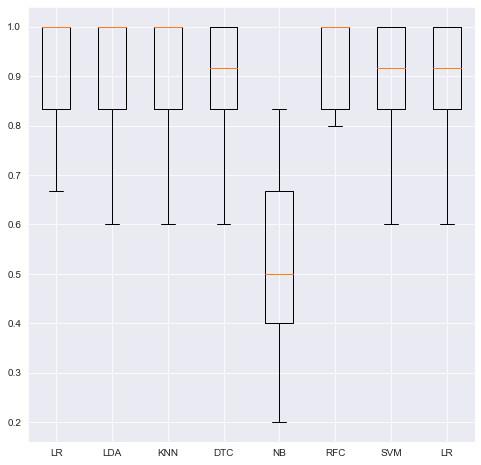

,algorithm,mean_pipeline5,std_pipeline5
0,LR,0.923333,0.100056
1,LDA,0.893333,0.136056
2,KNN,0.888333,0.138353
3,DTC,0.888333,0.127921
4,NB,0.526667,0.163163
5,RFC,0.931667,0.083981
6,SVM,0.896667,0.118275
7,LR,0.896667,0.118275


In [191]:
#Pipeline5:Columntransformer + OHE + MinMax Scaler+SelectKBest(chi2) + model
results_5 = []
names = []

for name, model in models:
    transformer = col_transformer
    scaler =MinMaxScaler()# para poder utilizar el Chi2 que sólo admite valores positivos
    #selector =SelectKBest(f_classif, k=3)
    #selector =SelectKBest(RFECV)
    selector =SelectKBest(chi2, k=3)
    pipeline5 = make_pipeline(transformer, scaler,selector,model)
    
    cv_technique = KFold(n_splits=20, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline5, X,y,cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   
    
    results_5.append(cv_results)
    names.append(name)
    

    
boxplots_algorithms(results_5, names)

results5 = pd.DataFrame(results_5)
results5['mean_pipeline5']=results5.mean(axis=1)
results5['std_pipeline5']=results5.std(axis=1)
results5['algorithm']=names
key_columns_r=['algorithm','mean_pipeline5','std_pipeline5']
results5 = results5[key_columns_r]  
results5
    

In [192]:
set_config(display='diagram')
pipeline5

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('selectkbest',
                 SelectKBest(k=3,
                             score_func=<function chi2 at 0x000002123B1660D0>)),
                ('svc', SVC())])

### Pipeline6: (OHE+Powertransformer+RFECV+Algorithms)

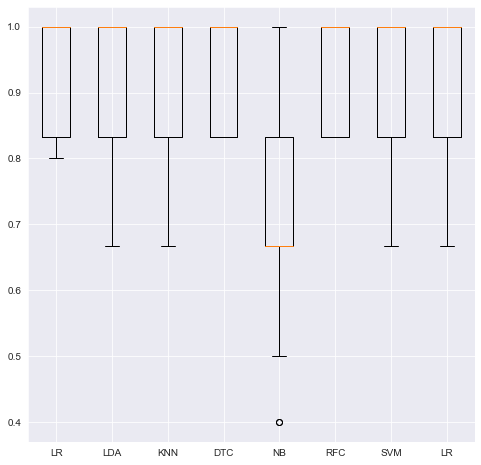

,algorithm,mean_pipeline6,std_pipeline6
0,LR,0.931667,0.083981
1,LDA,0.931667,0.099149
2,KNN,0.906667,0.112842
3,DTC,0.941667,0.079495
4,NB,0.728333,0.172972
5,RFC,0.950000,0.076376
6,SVM,0.931667,0.099149
7,LR,0.931667,0.099149


In [193]:
#Pipeline6:Columntransformer + OHE + Powertransformer + RFECV + model
results_6 = []
names = []

for name, model in models:
    transformer = col_transformer
    scaler = PowerTransformer(method='yeo-johnson')
    selector =RFECV(SVR(kernel="linear"), step=1, cv=5)
    pipeline6 = make_pipeline(transformer, scaler,selector,model)
    
    cv_technique = KFold(n_splits=20, shuffle=True, random_state=40)
    cv_results = cross_val_score(pipeline6, X,y,cv=cv_technique, scoring='accuracy')
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
   
    
    results_6.append(cv_results)
    names.append(name)
    

    
boxplots_algorithms(results_6, names)

results6 = pd.DataFrame(results_6)
results6['mean_pipeline6']=results6.mean(axis=1)
results6['std_pipeline6']=results6.std(axis=1)
results6['algorithm']=names
key_columns_r=['algorithm','mean_pipeline6','std_pipeline6']
results6 = results6[key_columns_r]  
results6
    

In [194]:
set_config(display='diagram')
pipeline6

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('powertransformer', PowerTransformer()),
                ('rfecv', RFECV(cv=5, estimator=SVR(kernel='linear'))),
                ('svc', SVC())])

## Model validation

In [195]:
result=pd.concat([results1,results2, results3, results4,results5,results6], axis=1)
result.drop(['std_pipeline1','std_pipeline2','std_pipeline3','std_pipeline4','std_pipeline5','std_pipeline6'], axis=1)


,algorithm,mean_pipeline1,algorithm,mean_pipeline2,algorithm,mean_pipeline3,algorithm,mean_pipeline4,algorithm,mean_pipeline5,algorithm,mean_pipeline6
0,LR,0.915000,LR,0.906667,LR,0.898333,LR,0.896667,LR,0.923333,LR,0.931667
1,LDA,0.923333,LDA,0.923333,LDA,0.925000,LDA,0.876667,LDA,0.893333,LDA,0.931667
2,KNN,0.923333,KNN,0.958333,KNN,0.958333,KNN,0.901667,KNN,0.888333,KNN,0.906667
3,DTC,0.948333,DTC,0.948333,DTC,0.903333,DTC,0.921667,DTC,0.888333,DTC,0.941667
4,NB,0.878333,NB,0.878333,NB,0.878333,NB,0.593333,NB,0.526667,NB,0.728333
5,RFC,0.941667,RFC,0.941667,RFC,0.931667,RFC,0.940000,RFC,0.931667,RFC,0.950000
6,SVM,0.923333,SVM,0.925000,SVM,0.925000,SVM,0.921667,SVM,0.896667,SVM,0.931667
7,LR,0.923333,LR,0.925000,LR,0.925000,LR,0.921667,LR,0.896667,LR,0.931667


    Escogemos los dos mejores del pipeline 1 a 3, sin feature selection y del pipeline 3 a 6 con feature selection.

    El modelo es el RandomForestClassifier 
    
    con valores de score medio:
    - pipeline 1: 0.941667
    - pipeline 6: 0.950000


## Model evaluation

### Tunning Pipeline1+kfold

In [196]:
""" Realizad un Tuneado del RandomForestClassifier para estimar cuál es la mejor configuración paramétrica
    Y comprobarlo con GridSearchCV """

param_grid = { 
    'model__n_estimators': [10, 15, 20,100],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8,10,12,14,16],
    'model__criterion' :['gini', 'entropy']
}

model = RandomForestClassifier()# codigo-alumno
transformer = col_transformer
scaler = PowerTransformer(method='yeo-johnson')

pipeline = Pipeline([('transformacion_columna', col_transformer), 
                    ('PowerTransformer', scaler),
                    ('model', model)])


cv_technique = KFold(n_splits=10, shuffle=True, random_state=40)
grid_model = GridSearchCV(pipeline,param_grid=param_grid) # codigo-alumno
grid_model.fit(X, y)

print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.9652173913043478
Pipeline(steps=[('transformacion_columna',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('PowerTransformer', PowerTransformer()),
                ('model',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=10))])


In [197]:
grid_model.n_features_in_

18

In [198]:
grid_model.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 12,
 'model__max_features': 'sqrt',
 'model__n_estimators': 10}

### Tunning Pipeline1+Stratifiedkfold

In [199]:
""" Realizad un Tuneado del RandomForestClassifier para estimar cuál es la mejor configuración paramétrica
    Y comprobarlo con GridSearchCV """

param_grid = { 
    'model__n_estimators': [10, 15, 20,100],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8,10,12,14,16],
    'model__criterion' :['gini', 'entropy']
}

model = RandomForestClassifier()# codigo-alumno
transformer = col_transformer
scaler = PowerTransformer(method='yeo-johnson')

pipeline = Pipeline([('transformacion_columna', col_transformer), 
                    ('PowerTransformer', scaler),
                    ('model', model)])


cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
grid_model = GridSearchCV(pipeline,param_grid=param_grid) # codigo-alumno
grid_model.fit(X, y)

print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.9652173913043478
Pipeline(steps=[('transformacion_columna',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('PowerTransformer', PowerTransformer()),
                ('model',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=15))])


In [200]:
grid_model.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__max_features': 'log2',
 'model__n_estimators': 15}

In [201]:
grid_model.n_features_in_

18

### Tunning Pipeline6+ kfold

In [202]:
""" Realizad un Tuneado del RandomForestClassifier para estimar cuál es la mejor configuración paramétrica
    Y comprobarlo con GridSearchCV """

param_grid = { 
    'model__n_estimators': [8,10,15],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8],
    'model__criterion' :['gini', 'entropy']
}

model = RandomForestClassifier()# codigo-alumno
transformer = col_transformer
scaler = PowerTransformer(method='yeo-johnson')
selector =RFECV(SVR(kernel="linear"), step=1, cv=5)

pipeline = Pipeline([('transformacion_columna', col_transformer), 
                    ('PowerTransformer', scaler),
                    ('Selector',selector),
                    ('model', model)])


cv_technique = KFold(n_splits=12, shuffle=True, random_state=40)
grid_model = GridSearchCV(pipeline,param_grid=param_grid) # codigo-alumno
grid_model.fit(X, y)

print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.9565217391304348
Pipeline(steps=[('transformacion_columna',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('PowerTransformer', PowerTransformer()),
                ('Selector', RFECV(cv=5, estimator=SVR(kernel='linear'))),
                ('model',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=10))])


In [203]:
grid_model.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 'log2',
 'model__n_estimators': 10}

In [204]:
grid_model.n_features_in_


18

### Tunning Pipeline6+Stratifiedkfold

In [205]:
""" Realizad un Tuneado del RandomForestClassifier para estimar cuál es la mejor configuración paramétrica
    Y comprobarlo con GridSearchCV """

param_grid = { 
    'model__n_estimators': [8, 10, 15],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__max_depth' : [4,5,6,7,8],
    'model__criterion' :['gini', 'entropy']
}

model = RandomForestClassifier()# codigo-alumno
transformer = col_transformer
scaler = PowerTransformer(method='yeo-johnson')
selector =RFECV(SVR(kernel="linear"), step=1, cv=5)

pipeline = Pipeline([('transformacion_columna', col_transformer), 
                    ('PowerTransformer', scaler),
                    ('Selector',selector),
                    ('model', model)])


cv_technique = StratifiedKFold(n_splits=12, shuffle=True, random_state=40)
grid_model = GridSearchCV(pipeline,param_grid=param_grid) # codigo-alumno
grid_model.fit(X, y)

print(grid_model.best_score_)
print(grid_model.best_estimator_)

0.9565217391304348
Pipeline(steps=[('transformacion_columna',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type',
                                                   'logged_in'])])),
                ('PowerTransformer', PowerTransformer()),
                ('Selector', RFECV(cv=5, estimator=SVR(kernel='linear'))),
                ('model',
                 RandomForestClassifier(max_depth=4, n_estimators=10))])


In [206]:
grid_model.n_features_in_

18

In [207]:
grid_model.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__max_features': 'auto',
 'model__n_estimators': 10}

### Confusion matrix 

En base a los parámetros del modelo ganador, RandomForestClassifier, del pipeline 1, calculamos la matriz de confussión.

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__max_features': 'auto',
 'model__n_estimators': 15}

In [212]:
#Cogiendo los valores del modelo que se estima ganador, se calcula matriz de confusión

model = RandomForestClassifier(criterion='gini',max_depth=4 ,max_features='auto',n_estimators= 10)
transformer = col_transformer
scaler = PowerTransformer(method='yeo-johnson')

pipeline = Pipeline([('transformacion_columna', col_transformer), 
                    ('PowerTransformer', scaler),
                    ('model', model)])

cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=40)
y_pred = cross_val_predict(pipeline, X,y, cv=cv_technique)

confusion_matrix(y_pred,y)

array([[103,   9],
       [  0,   3]], dtype=int64)

###### Matrix confusion

- **Exactitud = 106/115  un 92,2%** , es un modelo muy exacto , con muchas predicciones correctas frente al total de las mismas.
- **Precision = 3/12  un 25 %** , es un modelo muy poco preciso para una predición del valor verdadero
- **Sensibilidad = 5/8  un 100 %** , es un modelo muy sensible, no se le escapan los positivos
- **Especifidad = 103/112 un 91,9%**, es un modelo que es dificil de obtener falsos positivos.

El modelo ganador es RandomForestClassifier, se haescogide est al tener menos variables , aun teniendo un score un poco inferior a las otras opciones.

Con Score de : 0.9565217391304348

- model = RandomForestClassifier()# codigo-alumno
- transformer = col_transformer
- scaler = PowerTransformer(method='yeo-johnson')
- selector =RFECV(SVR(kernel="linear"), step=1, cv=5)

RandomForestClassifier, best parameters                 

- {'model__criterion': 'gini',
 - 'model__max_depth': 4,
 - 'model__max_features': 'auto',
 - 'model__n_estimators': 10}
                
                 

## Model deployment

In [216]:
dump(Pipeline,open('2021_sept_v001-RFC.pkl','wb')) # se crea el archivo versionado del modelo

In [217]:
modelx=load(open('2021_sept_v001-RFC.pkl','rb'))  # se lee el archivo

In [218]:
modelx  # Se le pregunta qué es

sklearn.pipeline.Pipeline